<h1 align=center><font size = 4>HUNT FOR A SUSTAINABLE BOROUGH TO LIVE IN LONDON</font></h1>

## Introduction 

London is a leading global city, demonstrating excellence in multiple areas including the arts, commerce, education, entertainment, research and development, fashion, finance, media, and tourism. Placed 2nd in the Global Cities Index Rank 2019 published by Kearney,  London accounts for 23% of the UK’s economic output with just 13% of the national population. It’s not only the world’s leading financial services centre but also Europe’s fastest growing technology hub and several of the world’s highest-ranking universities.
With its total population of London stood at just over 8 million, London is one of the most popular destinations for people all over the world. As per Annual population Survey from ONS, 36% of the Londoners are born outside of the UK with 41% comprising of Black and Minority Ethnicity. With regard to its ever-growing population, London has become the most ethnically diverse region in the UK with over 300 languages spoken.

## Business Problem

London is certainly a land of opportunities for many people from all over the world and as they move to the city for job opportunities and education, they are poised with dilemma of where to find a place to Live. In this report I have tried to provide a solution for the same taking into consideration few basic criteria per borough and comparing them. The criteria considered are as follows – 
* Rent Affordability - Borough wise Rent for past 2 years  
* House Affordability - House price per earnings for 2019
* Quality of Education – Average Attainment of 8 score
* Crime Safety – Crime Incident per month per 1000 people 2
* Public Transport Accessibility Levels
* Types of Venues available 


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Download and Explore Different Dataset</a>

2.  <a href="#item2">Explore London Borough's Venues</a>

3.  <a href="#item4">Cluster Boroughs</a>

4.  <a href="#item5">Analyze Clusters</a>  

5.  <a href="#item3">Analyze Each Neighborhood</a>
    </font>
    </div>


Import the important Libraries required

In [1]:
import requests # library to handle requests

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 100
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


# import geocoder
!pip install geocoder
import geocoder 

# library for Web Scraping
!pip install bs4
from bs4 import BeautifulSoup 

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from scipy.spatial.distance import cdist

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import branca.colormap as cmp

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## 1. Download and Explore Dataset

Scraping the London Borough Wikipedia page to get list of Borough and their designation as Inner or Outer. I have added City of London as Inner Bororugh for the sake of easier classification.

In [2]:
# url of the wiki page
url = 'https://en.wikipedia.org/wiki/London_boroughs'
rq_session = requests.Session()
response = rq_session.get(url,timeout=15)
print(response)

soup = BeautifulSoup(response.content, 'html.parser')
pretty_soup = soup.prettify()
all_tables=soup.find_all('table')
borough_table=soup.find('table', {"class":"wikitable sortable"})

<Response [200]>


In [3]:
# Create dict to collect wiki table data
borough_dict = {}

# Get table Headers
borough_header = ['Borough','Designation']

#Assign Headers as keys with inital 0 value
borough_dict = dict([(x,0) for x in borough_header])
print(borough_dict)

col1=[]
col2=[]
for row in borough_table.findAll("tr"):
    cells = row.findAll('td')
    if len(cells)>=3 : #Only extract table body not heading
        col1.append(cells[0].text.strip("\n"))
        col2.append(cells[1].text.strip("\n")) 
        
borough_dict['Borough'] = col1
borough_dict['Designation'] = col2

# convert dict to DataFrame
borough_df = pd.DataFrame(borough_dict)
borough_df['Borough'].replace({'Hammersmith[notes 2]':'Hammersmith and Fulham','Barking[notes 3]':'Barking and Dagenham'},inplace=True)
borough_df = borough_df.append({'Borough': 'City of London','Designation':'Inner' }, ignore_index=True)

# Top 5 records
print(borough_df.shape)
borough_df.head()

{'Borough': 0, 'Designation': 0}
(33, 2)


Borough Designation
0                  Camden       Inner
1               Greenwich       Inner
2                 Hackney       Inner
3  Hammersmith and Fulham       Inner
4               Islington       Inner

Next few blocks deals with importing the required Neghbourhood data collected from the ONS site and cleaning it to bring it in the format required to access it comforatblly for further usage.

Rent data per Borough for the year 2019 and 2020,

In [4]:
# Read Rent data for 2020
#labs/Coursera_Capstone/Coursera_Capstone/Final Project/Data
r20_df = pd.read_excel('Final Project/Data/londonrentalstatisticsq32020.xls',
                        sheet_name='Table 1.2',
                       skiprows=range(12),
                       skipfooter=20)

# Read Rent data for 2019
r19_df = pd.read_excel('Final Project/Data/londonrentalstatisticsq42019.xls',
                        sheet_name='Table 1.2',
                       skiprows=range(11),
                       skipfooter=20)

print ('Rent Data read into a pandas dataframe!')
print('Shape of 2020 data : {} and shape of 2019 data : {}'.format(r20_df.shape,r19_df.shape))

r20_df= r20_df.drop(['Unnamed: 0', 'Lower quartile','Median','Upper quartile'], axis=1).replace({'-': 0, '.' : 0,'..' : 0, '...' : 0})
r20_df.replace(0, np.nan, inplace=True)
r20_df.dropna(inplace = True)

r19_df= r19_df.drop(['Unnamed: 0', 'Lower quartile','Median','Upper quartile'], axis=1).replace({'-': 0, '.' : 0,'..' : 0, '...' : 0})
r19_df.replace(0, np.nan, inplace=True)
r19_df.dropna(inplace = True)

print('Shape of 2020 data : {} and shape of 2019 data : {}'.format(r20_df.shape,r19_df.shape))

Rent Data read into a pandas dataframe!
Shape of 2020 data : (217, 8) and shape of 2019 data : (217, 8)
Shape of 2020 data : (186, 4) and shape of 2019 data : (194, 4)


In [5]:
# Define a lambda function to compute the weighted mean:
wm20 = lambda x: np.average(x, weights=r20_df.loc[x.index, "Count of rents"])
wm19 = lambda x: np.average(x, weights=r19_df.loc[x.index, "Count of rents"])

r20_df = r20_df.groupby('Borough').agg(Rent_Count_2020 = ("Count of rents", "sum"), Avg_Rent_2020 =("Mean", wm20)).reset_index()
r19_df = r19_df.groupby('Borough').agg(Rent_Count_2019 = ("Count of rents", "sum"), Avg_Rent_2019 =("Mean", wm19)).reset_index()
avgrent_df = pd.merge(r20_df, r19_df, on="Borough").sort_values('Borough')
avgrent_df = avgrent_df.drop(['Rent_Count_2020', 'Rent_Count_2019'], axis=1)
avgrent_df.rename(columns={"Avg_Rent_2020": "Avg. Rent 2020", "Avg_Rent_2019": "Avg. Rent 2019"},inplace=True)
avgrent_df.set_index('Borough')
print(avgrent_df.shape)
avgrent_df.head()

(33, 3)


Borough  Avg. Rent 2020  Avg. Rent 2019
0  Barking and Dagenham     1208.235294     1202.723404
1                Barnet     1481.329341     1442.595376
2                Bexley     1111.702381     1119.492958
3                 Brent     1487.036036     1476.425197
4               Bromley     1317.445087     1331.671429

House Price per Earnings data for the year 2019

In [6]:
# Read House Price per Earnings data
housesus_df = pd.read_excel('Final Project/Data/ratio-house-price-earnings-residence-based.xlsx',
                        sheet_name='Median Earnings to Prices ratio')

print ('House Sustainability Data read into a pandas dataframe!')
print('House Sustainability data : {}'.format(housesus_df.shape))

housesus_df.columns =  housesus_df.columns.astype(str)
housesus_df.dropna(inplace=True)
housesus_df = housesus_df.drop(['New Code','Old Code'], axis=1).replace({'#': np.nan, ":": np.nan})
housesus_df.fillna(housesus_df.shift(1,axis=1),inplace=True)
housesus_df.rename(columns={"Area": "Borough", "2019": "House/Earnings"},inplace=True)
housesus_df.set_index('Borough')
housesus_df = housesus_df[['Borough','House/Earnings']]
print('House Sustainability data : {}'.format(housesus_df.shape))
housesus_df.head()

House Sustainability Data read into a pandas dataframe!
House Sustainability data : (46, 21)
House Sustainability data : (43, 2)


Borough House/Earnings
1        City of London          16.55
2  Barking and Dagenham          10.76
3                Barnet          14.21
4                Bexley           9.68
5                 Brent          15.74

GCSE Result data for 2019 as Education Quality data per Borough

In [7]:
# Read Education data
edu_df = pd.read_excel('Final Project/Data/gcse-results.xlsx',
                        sheet_name='2018-19')

print ('Education Data read into a pandas dataframe!')
print('Education data : {}'.format(edu_df.shape))


edu_df = edu_df[["Unnamed: 1","Unnamed: 3"]]
edu_df.dropna(inplace=True)
edu_df.replace({'.': 0},inplace=True)
edu_df.rename(columns={"Unnamed: 1": "Borough", "Unnamed: 3": "Avg. Attainment 8 Score"},inplace=True)
print('Education data : {}'.format(edu_df.shape))
edu_df.head()

Education Data read into a pandas dataframe!
Education data : (51, 22)
Education data : (45, 2)


Borough  Avg. Attainment 8 Score
3        City of London                      0.0
4  Barking and Dagenham                     46.4
5                Barnet                     57.1
6                Bexley                     49.6
7                 Brent                     50.2

Population per Borough Data

In [8]:
# Read data
population_df = pd.read_csv('Final Project/Data/housing-density-borough.csv')

print ('Population Projection 2019 Data read into a pandas dataframe!')
print('Population Projection 2019 data : {}'.format(population_df.shape))

population_df = population_df[population_df['Year'] == 2019]
population_df = population_df[['Name','Population']]
population_df.rename(columns={'Name':'Borough'},inplace=True)
print('Population Projection 2019 data : {}'.format(population_df.shape))
population_df.head()

Population Projection 2019 Data read into a pandas dataframe!
Population Projection 2019 data : (1872, 10)
Population Projection 2019 data : (36, 2)


Borough  Population
20         City of London        7953
72   Barking and Dagenham      214858
124                Barnet      402363
176                Bexley      252885
228                 Brent      340710

Crime Incident data per Borough for the year 2019

In [9]:
# Read data
crime_df = pd.read_csv('Final Project/Data/MPS Borough Level Crime (most recent 24 months).csv')

print ('Crime Data read into a pandas dataframe!')
print('Crime data : {}'.format(crime_df.shape))

crime_df = crime_df.groupby('LookUp_BoroughName').sum().reset_index()
crime_df['Crime Count'] = crime_df[[x for x in crime_df.columns if "2019" in x]].sum(axis = "columns").div(12)
crime_df = crime_df[['LookUp_BoroughName','Crime Count']]
crime_df.rename(columns={'LookUp_BoroughName':'Borough','Crime Count':'Crime Count per Month'},inplace=True)
col_dict = {'Borough':'City of London', 'Crime Count per Month':0}
crime_df = crime_df.append(col_dict,ignore_index=True)
print('Crime data : {}'.format(crime_df.shape))
crime_df.head()

Crime Data read into a pandas dataframe!
Crime data : (1559, 27)
Crime data : (34, 2)


Borough  Crime Count per Month
0  Barking and Dagenham            1682.500000
1                Barnet            2632.083333
2                Bexley            1506.000000
3                 Brent            2538.083333
4               Bromley            2100.250000

Using Crime Incident data and population data to arrive at "Monthly incidents per 1000 people"

In [10]:
crime_df = pd.merge(crime_df, population_df, on="Borough").sort_values('Borough')
crime_df['Monthly incidents per 1000 people'] = crime_df[['Crime Count per Month','Population']].apply(lambda row : row.iloc[0]*1000/row.iloc[1], axis=1)
crime_df = crime_df[['Borough','Monthly incidents per 1000 people']]
crime_df.head()

Borough  Monthly incidents per 1000 people
0  Barking and Dagenham                           7.830753
1                Barnet                           6.541564
2                Bexley                           5.955276
3                 Brent                           7.449395
4               Bromley                           6.282681

Average Public Transport Accessibility Data 

In [11]:
# Read data
ptal_df = pd.read_csv('Final Project/Data/Borough AvPTAI2015.csv')

print ('Public Transport Accessibility Data read into a pandas dataframe!')
print('Public Transport Accessibility data : {}'.format(ptal_df.shape))


ptal_df.rename(columns={'Borough Name':'Borough','AvPTAI2015' : 'Avg. PTAL'},inplace=True)
ptal_df.set_index('Borough')
ptal_df.drop(['Borough Code','PTAL'],axis=1,inplace=True)
print('Public Transport Accessibility data : {}'.format(ptal_df.shape))
ptal_df.head()

Public Transport Accessibility Data read into a pandas dataframe!
Public Transport Accessibility data : (33, 4)
Public Transport Accessibility data : (33, 2)


Borough  Avg. PTAL
0  Kingston upon Thames   5.425275
1               Croydon   6.757744
2               Bromley   3.592084
3              Hounslow   5.842208
4                Ealing   8.503510

Merging the the data collected above to give us a Single Dataframe with all the Neighburhood data

In [12]:
# Merging the columns of data collectde
london_df = pd.merge(avgrent_df, housesus_df, on="Borough").sort_values('Borough')
london_df = pd.merge(london_df, edu_df, on="Borough").sort_values('Borough')
london_df = pd.merge(london_df, ptal_df, on="Borough").sort_values('Borough')
london_df = pd.merge(london_df, crime_df, on="Borough").sort_values('Borough')
print('London data : {}'.format(london_df.shape))
london_df.head()

London data : (33, 7)


Borough  Avg. Rent 2020  Avg. Rent 2019 House/Earnings  \
0  Barking and Dagenham     1208.235294     1202.723404          10.76   
1                Barnet     1481.329341     1442.595376          14.21   
2                Bexley     1111.702381     1119.492958           9.68   
3                 Brent     1487.036036     1476.425197          15.74   
4               Bromley     1317.445087     1331.671429          10.73   

   Avg. Attainment 8 Score  Avg. PTAL  Monthly incidents per 1000 people  
0                     46.4   5.583730                           7.830753  
1                     57.1   5.542330                           6.541564  
2                     49.6   4.552927                           5.955276  
3                     50.2   9.223249                           7.449395  
4                     50.8   3.592084                           6.282681

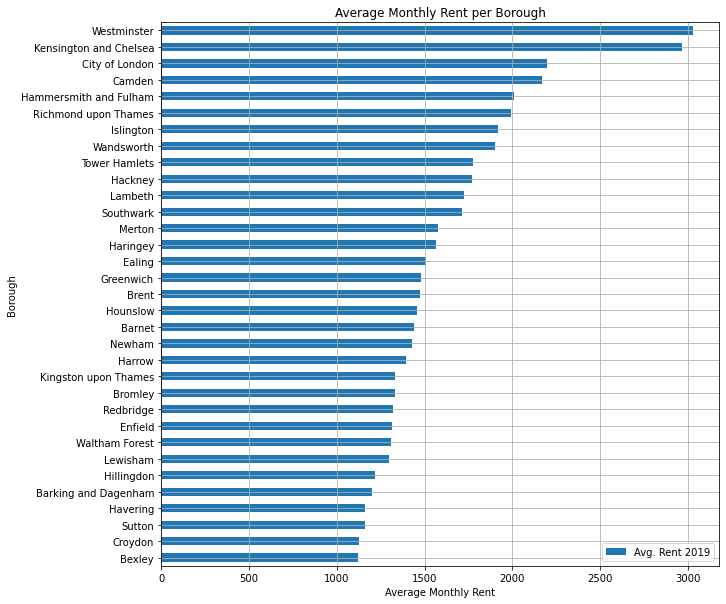

In [13]:
#Visualize Rental data
london_df[['Borough','Avg. Rent 2019']].set_index('Borough').sort_values('Avg. Rent 2019').plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Average Monthly Rent')
plt.title('Average Monthly Rent per Borough')
plt.show()

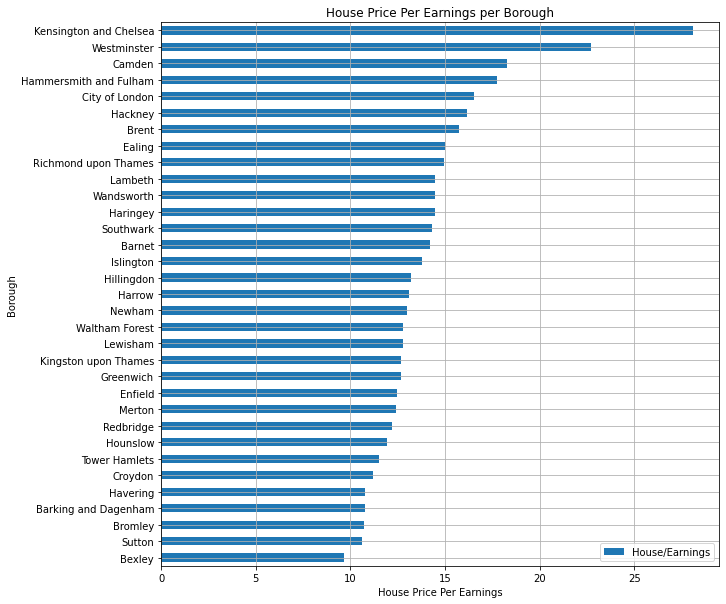

In [14]:
#Visualize House Price Per Earnings data
london_df[['Borough','House/Earnings']].set_index('Borough').sort_values('House/Earnings').plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('House Price Per Earnings')
plt.title('House Price Per Earnings per Borough')
plt.show()

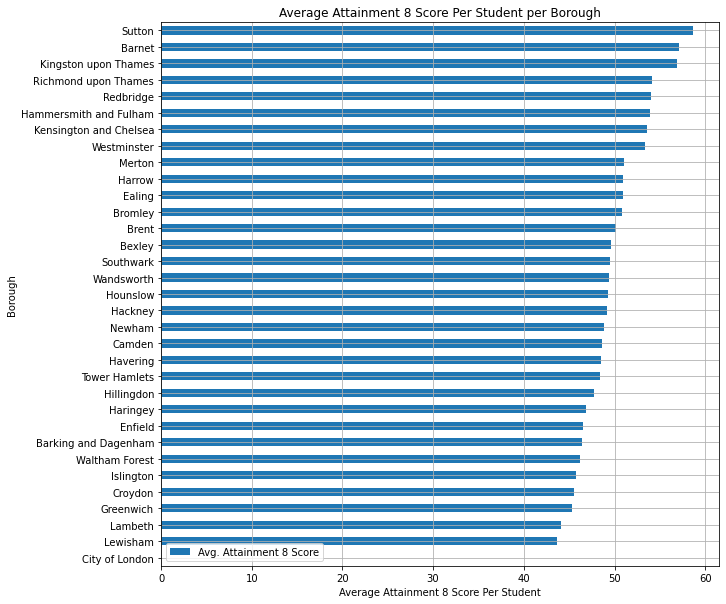

In [15]:
#Visualize Education data
london_df[['Borough','Avg. Attainment 8 Score']].set_index('Borough').sort_values('Avg. Attainment 8 Score').plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Average Attainment 8 Score Per Student')
plt.title('Average Attainment 8 Score Per Student per Borough')
plt.show()

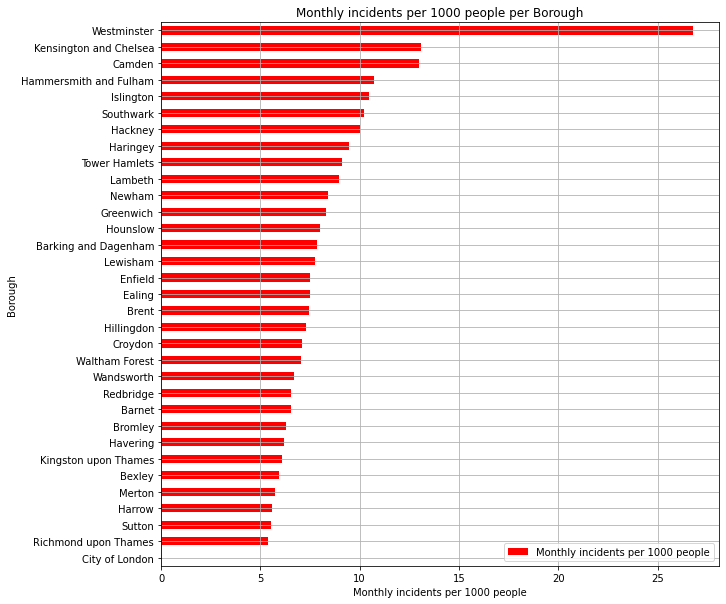

In [16]:
#Visualize Crime data
london_df[['Borough','Monthly incidents per 1000 people']].set_index('Borough').sort_values('Monthly incidents per 1000 people').plot(kind='barh', grid=True, figsize=(10,10), color='red')
plt.xlabel('Monthly incidents per 1000 people')
plt.title('Monthly incidents per 1000 people per Borough')
plt.show()

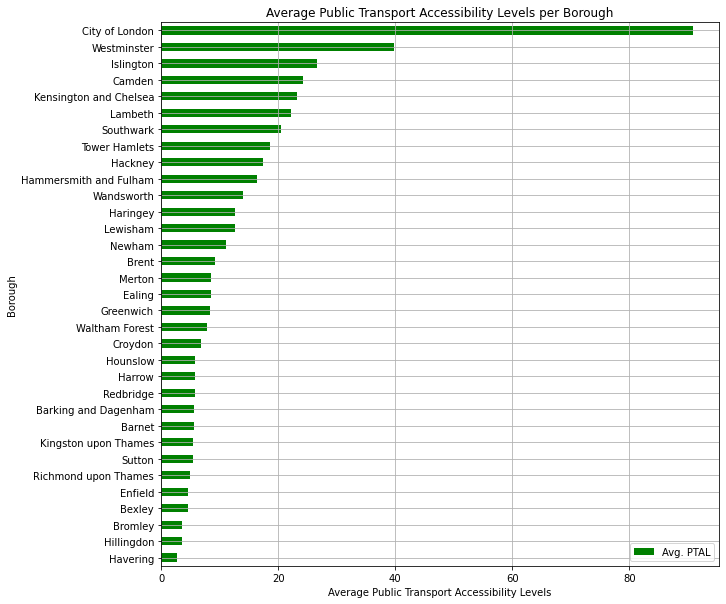

In [17]:
#Visualize Ease of Access to Transportation data
london_df[['Borough','Avg. PTAL']].set_index('Borough').sort_values('Avg. PTAL').plot(kind='barh', grid=True, figsize=(10,10), color='green')
plt.xlabel('Average Public Transport Accessibility Levels')
plt.title('Average Public Transport Accessibility Levels per Borough')
plt.show()

Normalizing the Neighbourhood data so that it have all the data in a scale where its easier to form Clusters

In [18]:
borough = london_df['Borough']
columns = london_df.columns
x = london_df.drop(['Borough'],axis=1).values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
NormalizedLondon_df = pd.DataFrame(x_scaled)
NormalizedLondon_df.insert(loc=0, column='Borough', value=borough)
NormalizedLondon_df.set_index('Borough')
NormalizedLondon_df.columns = columns
print('Normalized London data : {}'.format(NormalizedLondon_df.shape))
NormalizedLondon_df[['Avg. Rent 2020','Avg. Rent 2019','Monthly incidents per 1000 people','House/Earnings']] = NormalizedLondon_df[['Avg. Rent 2020','Avg. Rent 2019','Monthly incidents per 1000 people','House/Earnings']].sub(1).abs()
NormalizedLondon_df.rename(columns={'Monthly incidents per 1000 people':'Crime Safety','House/Earnings' : 'House Affordability','Avg. Rent 2019':'Rent Affordability','Avg. Attainment 8 Score':'Quality Education'},inplace=True)
NormalizedLondon_df.set_index('Borough')
NormalizedLondon_df.drop(['Avg. Rent 2020'],axis=1,inplace=True)
NormalizedLondon_df.head()

Normalized London data : (33, 7)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype object was converted to float64 by MinMaxScaler.



Borough  Rent Affordability  House Affordability  \
0  Barking and Dagenham            0.956335             0.941304   
1                Barnet            0.830493             0.753804   
2                Bexley            1.000000             1.000000   
3                 Brent            0.812745             0.670652   
4               Bromley            0.888686             0.942935   

   Quality Education  Avg. PTAL  Crime Safety  
0           0.791809   0.032206      0.707374  
1           0.974403   0.031736      0.755550  
2           0.846416   0.020499      0.777459  
3           0.856655   0.073538      0.721625  
4           0.866894   0.009588      0.765224

The Sum of all the Neighbourhood data is named as **Neighbourhood Score** which essential gives us a way to rank each Borough.

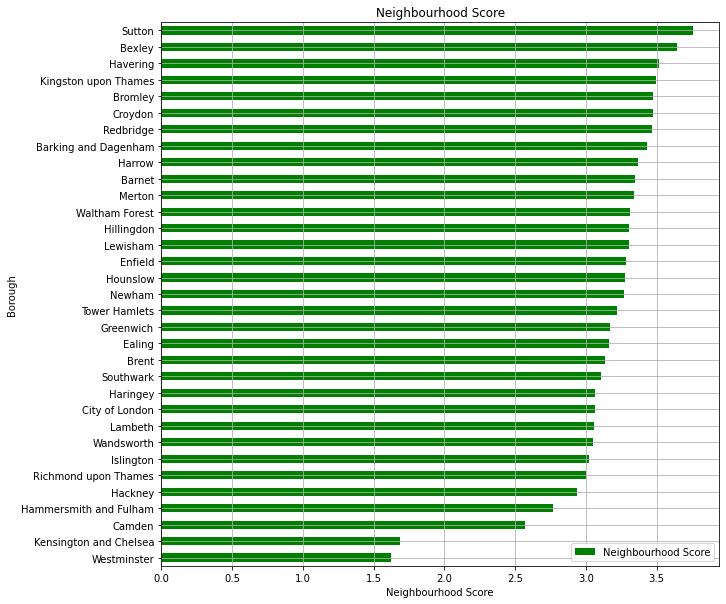

In [19]:
Neighbourhood_df = NormalizedLondon_df.copy()
Neighbourhood_df['Neighbourhood Score'] = NormalizedLondon_df.sum(axis = 1, numeric_only=True)
Neighbourhood_df[['Borough','Neighbourhood Score']].sort_values('Neighbourhood Score').set_index('Borough').plot(kind='barh', grid=True, figsize=(10,10), color='green')
plt.xlabel('Neighbourhood Score')
plt.title('Neighbourhood Score')
plt.show()

## 2. Explore London Borough's Venues

Collect the Latitude and Longitude of the Boroughs of London using Geocoder. 

In [20]:
address = 'London, UK'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [21]:
def getLatLong(borough):

    # initialize your variable to None
    lat_lng_coords = None
    search_query = '{}, London,UK'.format(borough)
    count = 0
    # loop until you get the coordinates
    try:
        while(lat_lng_coords is None):
            g = geocoder.arcgis(search_query)
            lat_lng_coords = g.latlng
            #print(" Location {} has latitude : {} and longitude : {}".format(postalCodes,lat_lng_coords[0],lat_lng_coords[1]))
    except IndexError:
        print('Exception occured')
        latitude = 0.0
        longitude = 0.0
        return [latitude,longitude]

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    #print(latitude, longitude)
    return [latitude, longitude]

In [22]:
latlong_list = london_df['Borough'].apply(getLatLong).tolist()

print('latitude/longitude data obtained ')

london_df[['Latitude','Longitude']]=pd.DataFrame(latlong_list,columns=['Latitude', 'Longitude'])

latitude/longitude data obtained 


In [23]:
print(london_df.shape)
london_df.head()

(33, 9)


Borough  Avg. Rent 2020  Avg. Rent 2019 House/Earnings  \
0  Barking and Dagenham     1208.235294     1202.723404          10.76   
1                Barnet     1481.329341     1442.595376          14.21   
2                Bexley     1111.702381     1119.492958           9.68   
3                 Brent     1487.036036     1476.425197          15.74   
4               Bromley     1317.445087     1331.671429          10.73   

   Avg. Attainment 8 Score  Avg. PTAL  Monthly incidents per 1000 people  \
0                     46.4   5.583730                           7.830753   
1                     57.1   5.542330                           6.541564   
2                     49.6   4.552927                           5.955276   
3                     50.2   9.223249                           7.449395   
4                     50.8   3.592084                           6.282681   

    Latitude  Longitude  
0  51.543932   0.133157  
1  51.527095  -0.066826  
2  51.452078   0.069931  
3  51.609783  -0.194672  
4  51.601511  -0.066365

Use of **Foursquare api** to get venues data around the Boroughs in the Radius of 900m and limited to 300 venues per Borough. This is based on the assumption the venues pattern in the Borough radius would replicate if we increase the Radius further. Also, The further we go away from the radius considered the lower is the probability of new people choosing to live as it would increase the transit hussle. 

In [24]:
CLIENT_ID = 'JFTNCFJGQHEMCSANIAS0TSRBHYBSKSO3AKAHXO4AOQE15KBA' # your Foursquare ID
CLIENT_SECRET = 'M5LBOZUV5PS1YQ2UTTC4W2EIL1ACQMRMTQCODCWTD5NBRJS3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 300 # A default Foursquare API limit value
radius = 900 # define radius

Code to get Main cateogory of the venues so that grouping is easier and at broader level.

In [25]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION )
res = requests.get(url).json()["response"]['categories']

In [26]:
headCat = {"Id":[],"Venue Category":[],"Main Category":[]};
headCat_columns = ['Id','Venue Category','Main Category']

def add_cat_to_df(main_category, categories):
    #print(categories)
    if not categories :
        return
    for category in categories :
        headCat['Id'].append(category['id'])
        headCat['Venue Category'].append(category['name'])
        headCat['Main Category'].append(main_category)
        add_cat_to_df(main_category, category['categories'])
    return
    
for mains in res :
    main_category = mains['name']
    sub_category = mains['categories']
    add_cat_to_df(main_category, mains['categories'])

headCat.keys()
headCat_df = pd.DataFrame(headCat,columns = headCat_columns) 
print('There are {} uniques categories.'.format(len(headCat_df['Main Category'].unique())))
headCat_df.head()

There are 10 uniques categories.


Id Venue Category         Main Category
0  56aa371be4b08b9a8d5734db   Amphitheater  Arts & Entertainment
1  4fceea171983d5d06c3e9823       Aquarium  Arts & Entertainment
2  4bf58dd8d48988d1e1931735         Arcade  Arts & Entertainment
3  4bf58dd8d48988d1e2931735    Art Gallery  Arts & Entertainment
4  4bf58dd8d48988d1e4931735  Bowling Alley  Arts & Entertainment

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=900):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #print(url)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']   
    return(nearby_venues)

In [28]:
london_venues = getNearbyVenues(names=london_df['Borough'],
                                   latitudes=london_df['Latitude'],
                                   longitudes=london_df['Longitude']
                                  )

print(london_venues.shape)
london_venues.head()

(2222, 7)


Borough  Borough Latitude  Borough Longitude  \
0  Barking and Dagenham         51.543932           0.133157   
1  Barking and Dagenham         51.543932           0.133157   
2  Barking and Dagenham         51.543932           0.133157   
3  Barking and Dagenham         51.543932           0.133157   
4                Barnet         51.527095          -0.066826   

                                  Venue  Venue Latitude  Venue Longitude  \
0                            Co-op Food       51.540093         0.127522   
1                         Parsloes Park       51.545027         0.125598   
2  Becontree London Underground Station       51.540335         0.127061   
3               Children And Baby Gifts       51.538942         0.123285   
4                       The King's Arms       51.525754        -0.065868   

  Venue Category  
0  Grocery Store  
1           Park  
2  Metro Station  
3      Gift Shop  
4            Pub

In [29]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))
london_venues = pd.merge(london_venues,headCat_df, on='Venue Category' )
print('There are {} uniques categories.'.format(len(london_venues['Main Category'].unique())))
print(london_venues.shape)

There are 266 uniques categories.
There are 9 uniques categories.
(2221, 9)


In [30]:
london_venues.head()

Borough  Borough Latitude  Borough Longitude  \
0  Barking and Dagenham         51.543932           0.133157   
1                 Brent         51.609783          -0.194672   
2               Bromley         51.601511          -0.066365   
3                Camden         51.532360          -0.127960   
4        City of London         51.520500          -0.097430   

                       Venue  Venue Latitude  Venue Longitude Venue Category  \
0                 Co-op Food       51.540093         0.127522  Grocery Store   
1  International Supermarket       51.615275        -0.190575  Grocery Store   
2                    Iceland       51.594401        -0.069324  Grocery Store   
3            M&S Simply Food       51.532800        -0.127123  Grocery Store   
4            M&S Simply Food       51.513590        -0.095297  Grocery Store   

                         Id   Main Category  
0  4bf58dd8d48988d118951735  Shop & Service  
1  4bf58dd8d48988d118951735  Shop & Service  
2  4bf58dd8d48988d118951735  Shop & Service  
3  4bf58dd8d48988d118951735  Shop & Service  
4  4bf58dd8d48988d118951735  Shop & Service

OneHot coding to convert the categorical venues data in numeric data. 

In [31]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Main Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe ans move column to the first column
london_onehot['Borough'] = london_venues['Borough'] 
first_col = london_onehot.pop('Borough')
london_onehot.insert(0, 'Borough', first_col)

print(london_onehot.shape)
london_onehot.head()

(2221, 10)


Borough  Arts & Entertainment  College & University  Food  \
0  Barking and Dagenham                     0                     0     0   
1                 Brent                     0                     0     0   
2               Bromley                     0                     0     0   
3                Camden                     0                     0     0   
4        City of London                     0                     0     0   

   Nightlife Spot  Outdoors & Recreation  Professional & Other Places  \
0               0                      0                            0   
1               0                      0                            0   
2               0                      0                            0   
3               0                      0                            0   
4               0                      0                            0   

   Residence  Shop & Service  Travel & Transport  
0          0               1                   0  
1          0               1                   0  
2          0               1                   0  
3          0               1                   0  
4          0               1                   0

Group rows by Borough and by taking the mean of the frequency of occurrence of each category

In [32]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
print(london_grouped.shape)
london_grouped.head()

(33, 10)


Borough  Arts & Entertainment  College & University      Food  \
0  Barking and Dagenham                0.0000                   0.0  0.000000   
1                Barnet                0.0200                   0.0  0.420000   
2                Bexley                0.0000                   0.0  0.357143   
3                 Brent                0.0000                   0.0  0.677419   
4               Bromley                0.0625                   0.0  0.156250   

   Nightlife Spot  Outdoors & Recreation  Professional & Other Places  \
0        0.000000               0.250000                         0.00   
1        0.190000               0.130000                         0.02   
2        0.071429               0.357143                         0.00   
3        0.064516               0.096774                         0.00   
4        0.281250               0.093750                         0.00   

   Residence  Shop & Service  Travel & Transport  
0        0.0        0.500000              0.2500  
1        0.0        0.210000              0.0100  
2        0.0        0.214286              0.0000  
3        0.0        0.161290              0.0000  
4        0.0        0.218750              0.1875

Get the most visited spots per Borough

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted.head()

Borough  1st Most Common Venue 2nd Most Common Venue  \
0  Barking and Dagenham         Shop & Service    Travel & Transport   
1                Barnet                   Food        Shop & Service   
2                Bexley  Outdoors & Recreation                  Food   
3                 Brent                   Food        Shop & Service   
4               Bromley         Nightlife Spot        Shop & Service   

   3rd Most Common Venue  4th Most Common Venue        5th Most Common Venue  \
0  Outdoors & Recreation              Residence  Professional & Other Places   
1         Nightlife Spot  Outdoors & Recreation  Professional & Other Places   
2         Shop & Service         Nightlife Spot           Travel & Transport   
3  Outdoors & Recreation         Nightlife Spot           Travel & Transport   
4     Travel & Transport                   Food        Outdoors & Recreation   

  6th Most Common Venue        7th Most Common Venue  
0        Nightlife Spot                         Food  
1  Arts & Entertainment           Travel & Transport  
2             Residence  Professional & Other Places  
3             Residence  Professional & Other Places  
4  Arts & Entertainment                    Residence

## 3. Cluster Boroughs

Using Elbow Method and Silhouette Score to come up with the optinla level of clusters

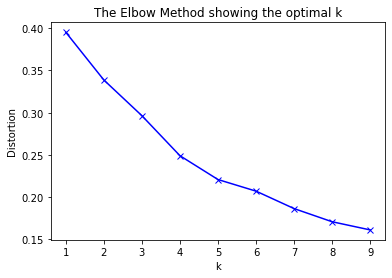

In [35]:
london_grouped_clustering = pd.merge(NormalizedLondon_df, london_grouped, on="Borough").sort_values('Borough')
london_grouped_clustering = london_grouped_clustering.drop(['Borough'], 1)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(london_grouped_clustering)
    kmeanModel.fit(london_grouped_clustering)
    distortions.append(sum(np.min(cdist(london_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / london_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


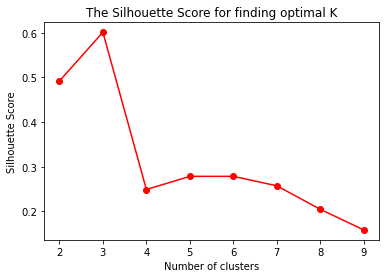

In [36]:
max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, n_init=40, random_state = 0).fit_predict(london_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(london_grouped_clustering, kmeans)
    scores.append(score)

#plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.title('The Silhouette Score for finding optimal K')
plt.show()

In [37]:
london_grouped_clustering.head()

Rent Affordability  House Affordability  Quality Education  Avg. PTAL  \
0            0.956335             0.941304           0.791809   0.032206   
1            0.830493             0.753804           0.974403   0.031736   
2            1.000000             1.000000           0.846416   0.020499   
3            0.812745             0.670652           0.856655   0.073538   
4            0.888686             0.942935           0.866894   0.009588   

   Crime Safety  Arts & Entertainment  College & University      Food  \
0      0.707374                0.0000                   0.0  0.000000   
1      0.755550                0.0200                   0.0  0.420000   
2      0.777459                0.0000                   0.0  0.357143   
3      0.721625                0.0000                   0.0  0.677419   
4      0.765224                0.0625                   0.0  0.156250   

   Nightlife Spot  Outdoors & Recreation  Professional & Other Places  \
0        0.000000               0.250000                         0.00   
1        0.190000               0.130000                         0.02   
2        0.071429               0.357143                         0.00   
3        0.064516               0.096774                         0.00   
4        0.281250               0.093750                         0.00   

   Residence  Shop & Service  Travel & Transport  
0        0.0        0.500000              0.2500  
1        0.0        0.210000              0.0100  
2        0.0        0.214286              0.0000  
3        0.0        0.161290              0.0000  
4        0.0        0.218750              0.1875

Run _k_-means to cluster the neighborhood into 3 clusters.

In [38]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([1, 1, 1, 1, 1], dtype=int32)

New dataframe that includes the cluster as well as the top 7 venues category  for each neighborhood.

In [39]:
# add clustering labels
#borough_venues_sorted.drop('Cluster Labels',axis=1)
borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = london_df

#print('There are {} uniques categories.'.format(len(toronto_merged['Neighborhood'].unique())))
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(borough_venues_sorted.set_index('Borough'), on='Borough')
london_merged.dropna(inplace=True)
print(london_merged.shape)

(33, 17)


In [40]:
london_merged

Borough  Avg. Rent 2020  Avg. Rent 2019 House/Earnings  \
0     Barking and Dagenham     1208.235294     1202.723404          10.76   
1                   Barnet     1481.329341     1442.595376          14.21   
2                   Bexley     1111.702381     1119.492958           9.68   
3                    Brent     1487.036036     1476.425197          15.74   
4                  Bromley     1317.445087     1331.671429          10.73   
5                   Camden     2027.228916     2171.184615          18.28   
6           City of London     2071.000000     2198.600000          16.55   
7                  Croydon     1149.169399     1126.730924          11.18   
8                   Ealing     1563.243802     1510.320312             15   
9                  Enfield     1303.870370     1313.475610          12.46   
10               Greenwich     1497.451613     1480.238636           12.7   
11                 Hackney     1861.706294     1769.586207          16.14   
12  Hammersmith and Fulham     2022.930481     2010.779070          17.74   
13                Haringey     1638.631579     1563.450000          14.48   
14                  Harrow     1449.181818     1394.981308          13.09   
15                Havering     1173.688312     1159.202020          10.79   
16              Hillingdon     1244.778626     1218.068966          13.19   
17                Hounslow     1420.363636     1458.814815          11.95   
18               Islington     1949.666667     1917.857143          13.78   
19  Kensington and Chelsea     3001.867470     2964.680180          28.08   
20    Kingston upon Thames     1297.031915     1332.025424           12.7   
21                 Lambeth     1864.196581     1726.454545           14.5   
22                Lewisham     1315.432432     1299.909091          12.78   
23                  Merton     1647.867188     1574.687500          12.39   
24                  Newham     1473.013158     1426.398773          13.01   
25               Redbridge     1310.815126     1319.348571          12.18   
26    Richmond upon Thames     1944.076087     1990.380645          14.96   
27               Southwark     1706.084746     1712.898477          14.29   
28                  Sutton     1137.150685     1158.394231           10.6   
29           Tower Hamlets     1810.732026     1777.375000          11.51   
30          Waltham Forest     1355.307143     1310.406780          12.79   
31              Wandsworth     1940.881657     1898.714829          14.49   
32             Westminster     2840.916667     3025.622378           22.7   

    Avg. Attainment 8 Score  Avg. PTAL  Monthly incidents per 1000 people  \
0                      46.4   5.583730                           7.830753   
1                      57.1   5.542330                           6.541564   
2                      49.6   4.552927                           5.955276   
3                      50.2   9.223249                           7.449395   
4                      50.8   3.592084                           6.282681   
5                      48.6  24.316782                          12.983349   
6                       0.0  90.802508                           0.000000   
7                      45.5   6.757744                           7.116415   
8                      50.9   8.503510                           7.491398   
9                      46.5   4.627966                           7.506579   
10                     45.3   8.378170                           8.310317   
11                     49.2  17.478762                          10.029676   
12                     53.9  16.325973                          10.698195   
13                     46.9  12.614837                           9.462060   
14                     50.9   5.822306                           5.593414   
15                     48.5   2.747859                           6.184235   
16                     47.7   3.561241                           7.318698   
17            

## 4.Analyze Clusters

Grouping the stats by Cluster to analyize each cluster

In [41]:
cluster_stats = london_grouped_clustering.copy()
cluster_stats.insert(0, 'Cluster Labels', kmeans.labels_)
cluster_stats_count = cluster_stats.groupby('Cluster Labels').count()
cluster_stats =  cluster_stats.groupby('Cluster Labels').mean().reset_index()
cluster_stats = pd.concat([cluster_stats, pd.DataFrame({'Count': london_merged.groupby('Cluster Labels').count().iloc[:,0]})], axis=1 )
cluster_stats.set_index('Cluster Labels')
cluster_stats

Cluster Labels  Rent Affordability  House Affordability  Quality Education  \
0               0            0.253160             0.346739           0.893771   
1               1            0.818877             0.823292           0.844344   
2               2            0.433875             0.626630           0.000000   

   Avg. PTAL  Crime Safety  Arts & Entertainment  College & University  \
0   0.263089      0.406290              0.082331              0.000000   
1   0.077602      0.721073              0.043724              0.000714   
2   1.000000      1.000000              0.110000              0.000000   

       Food  Nightlife Spot  Outdoors & Recreation  \
0  0.484601        0.097304               0.138977   
1  0.402287        0.139022               0.142169   
2  0.440000        0.150000               0.170000   

   Professional & Other Places  Residence  Shop & Service  Travel & Transport  \
0                     0.022500   0.000000        0.115687            0.058600   
1                     0.004662   0.000357        0.203873            0.063193   
2                     0.020000   0.000000        0.070000            0.040000   

   Count  
0      4  
1     28  
2      1

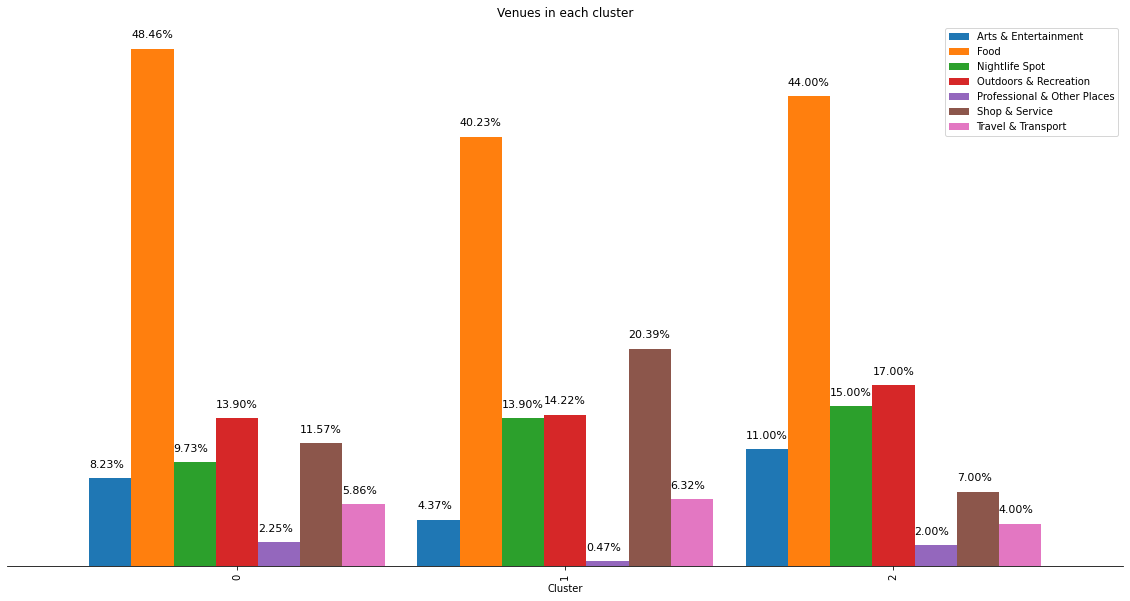

In [42]:
ax = cluster_stats[['Arts & Entertainment','Food','Nightlife Spot','Outdoors & Recreation','Professional & Other Places','Shop & Service','Travel & Transport']].plot(kind='bar', figsize=(20,10), width=.9)
ax.get_yaxis().set_ticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:
    label = "{:.2f}%".format(p.get_height()*100)
    ax.annotate(label, (p.get_x(), p.get_height() + 0.01), fontsize=11)
plt.xlabel("Cluster")
plt.title('Venues in each cluster')
plt.show()

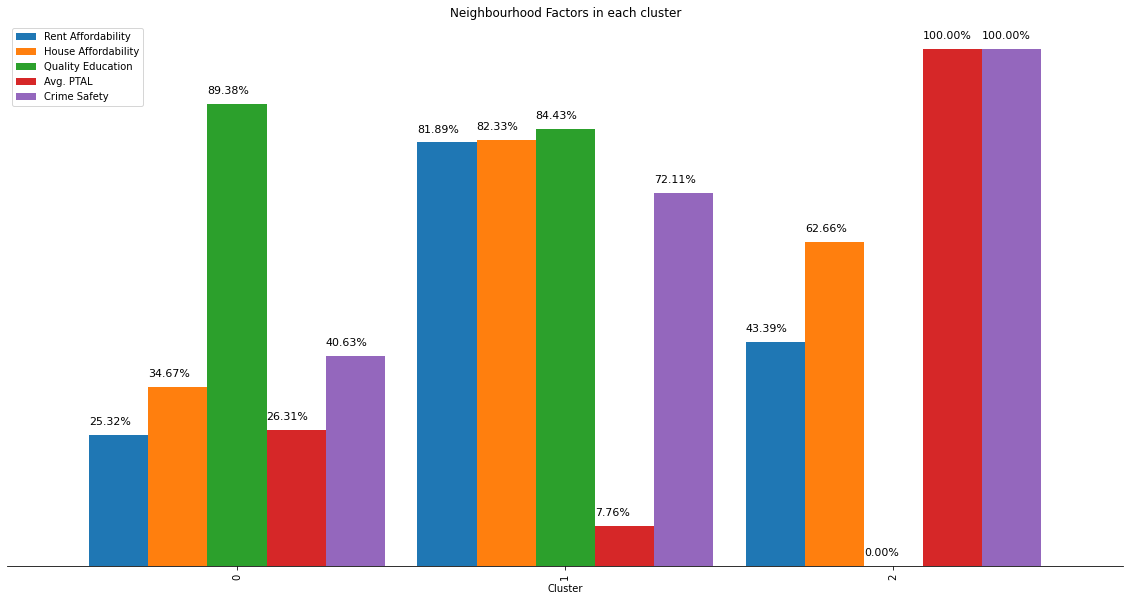

In [43]:
ax = cluster_stats[['Rent Affordability','House Affordability','Quality Education','Avg. PTAL','Crime Safety']].plot(kind='bar', figsize=(20,10), width=.9)
ax.get_yaxis().set_ticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:
    label = "{:.2f}%".format(p.get_height()*100)
    ax.annotate(label, (p.get_x(), p.get_height() + 0.02), fontsize=11)
plt.xlabel("Cluster")
plt.title('Neighbourhood Factors in each cluster')
plt.show()

Ploting the Clusters on the Map

In [44]:
# create map
cluster_labels = [
    'Cluster 0 - "Exorbitant"',
    'Cluster 1 - "Economical"',
    'Cluster 2 - "Expensive"'
]
london_clusters = folium.Map(location=[location.latitude,location.longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Borough'], london_merged['Cluster Labels']):
    label = folium.Popup("{} | {}".format(name, cluster_labels[cluster]), max_width=200)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(london_clusters)

london_clusters

In [45]:
london_geo = r'london_boroughs_proper.geojson' # geojson file

# create a plain world map
london_map = folium.Map(location= [location.latitude,location.longitude], zoom_start=10)

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
london_map.choropleth(
    geo_data=london_geo,
    data=london_merged,
    columns=['Borough', 'Cluster Labels'],
    key_on='feature.properties.name',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Cluster Labels'
)

london_map

In [46]:
boroughgrading_df = london_grouped_clustering.copy()
boroughgrading_df.insert(0, 'Borough', london_merged['Borough'])
boroughgrading_df.insert(1, 'Cluster Labels', kmeans.labels_)
boroughgrading_df = pd.merge(boroughgrading_df, borough_df[['Borough','Designation']], how="left", on=["Borough"])
boroughgrading_df['Neighbourhood Score'] = boroughgrading_df[['Rent Affordability','House Affordability','Quality Education','Avg. PTAL','Crime Safety']].sum(axis = 1)
boroughgrading_df = boroughgrading_df[['Borough','Designation','Cluster Labels','Neighbourhood Score']]
boroughgrading_df.rename(columns={'Cluster Labels':'Sustenance Level'},inplace=True)
boroughgrading_df['Sustenance Level'].replace({0:'Expensive',1 :'Economical',2:'Exorbitant'})
#boroughgrading_df['Sustenance Level'] = pd.Categorical(boroughgrading_df['Sustenance Level'], 
 #                     categories=["High","Medium","Low"],
  #                    ordered=True)
boroughgrading_df.head()

Borough Designation  Sustenance Level  Neighbourhood Score
0  Barking and Dagenham       Outer                 1             3.429029
1                Barnet       Outer                 1             3.345985
2                Bexley       Outer                 1             3.644374
3                 Brent       Outer                 1             3.135216
4               Bromley       Outer                 1             3.473327

In [47]:
boroughgrading_df['Sustenance Level'].replace({0:'Expensive',1 :'Economical',2:'Exorbitant'},inplace=True)
boroughgrading_df['Sustenance Level'] = pd.Categorical(boroughgrading_df['Sustenance Level'], 
                      categories=["Exorbitant","Expensive","Economical"],
                      ordered=True)

In [48]:
boroughgrading_df.sort_values(by=['Sustenance Level','Designation','Neighbourhood Score'], inplace=True)
boroughgrading_df

Borough Designation Sustenance Level  Neighbourhood Score
6           City of London       Inner       Exorbitant             3.060506
32             Westminster       Inner        Expensive             1.623881
19  Kensington and Chelsea       Inner        Expensive             1.689735
5                   Camden       Inner        Expensive             2.569996
12  Hammersmith and Fulham       Inner        Expensive             2.768585
11                 Hackney       Inner       Economical             2.939945
18               Islington       Inner       Economical             3.019902
31              Wandsworth       Inner       Economical             3.050591
21                 Lambeth       Inner       Economical             3.059469
27               Southwark       Inner       Economical             3.103356
10               Greenwich       Inner       Economical             3.173046
29           Tower Hamlets       Inner       Economical             3.220094
22                Lewisham       Inner       Economical             3.305107
26    Richmond upon Thames       Outer       Economical             3.003035
13                Haringey       Outer       Economical             3.065031
3                    Brent       Outer       Economical             3.135216
8                   Ealing       Outer       Economical             3.159853
24                  Newham       Outer       Economical             3.270877
17                Hounslow       Outer       Economical             3.276462
9                  Enfield       Outer       Economical             3.281500
16              Hillingdon       Outer       Economical             3.307263
30          Waltham Forest       Outer       Economical             3.313820
23                  Merton       Outer       Economical             3.337109
1                   Barnet       Outer       Economical             3.345985
14                  Harrow       Outer       Economical             3.364643
0     Barking and Dagenham       Outer       Economical             3.429029
25               Redbridge       Outer       Economical             3.469958
7                  Croydon       Outer       Economical             3.470738
4                  Bromley       Outer       Economical             3.473327
20    Kingston upon Thames       Outer       Economical             3.497726
15                Havering       Outer       Economical             3.515389
2                   Bexley       Outer       Economical             3.644374
28                  Sutton       Outer       Economical             3.752440

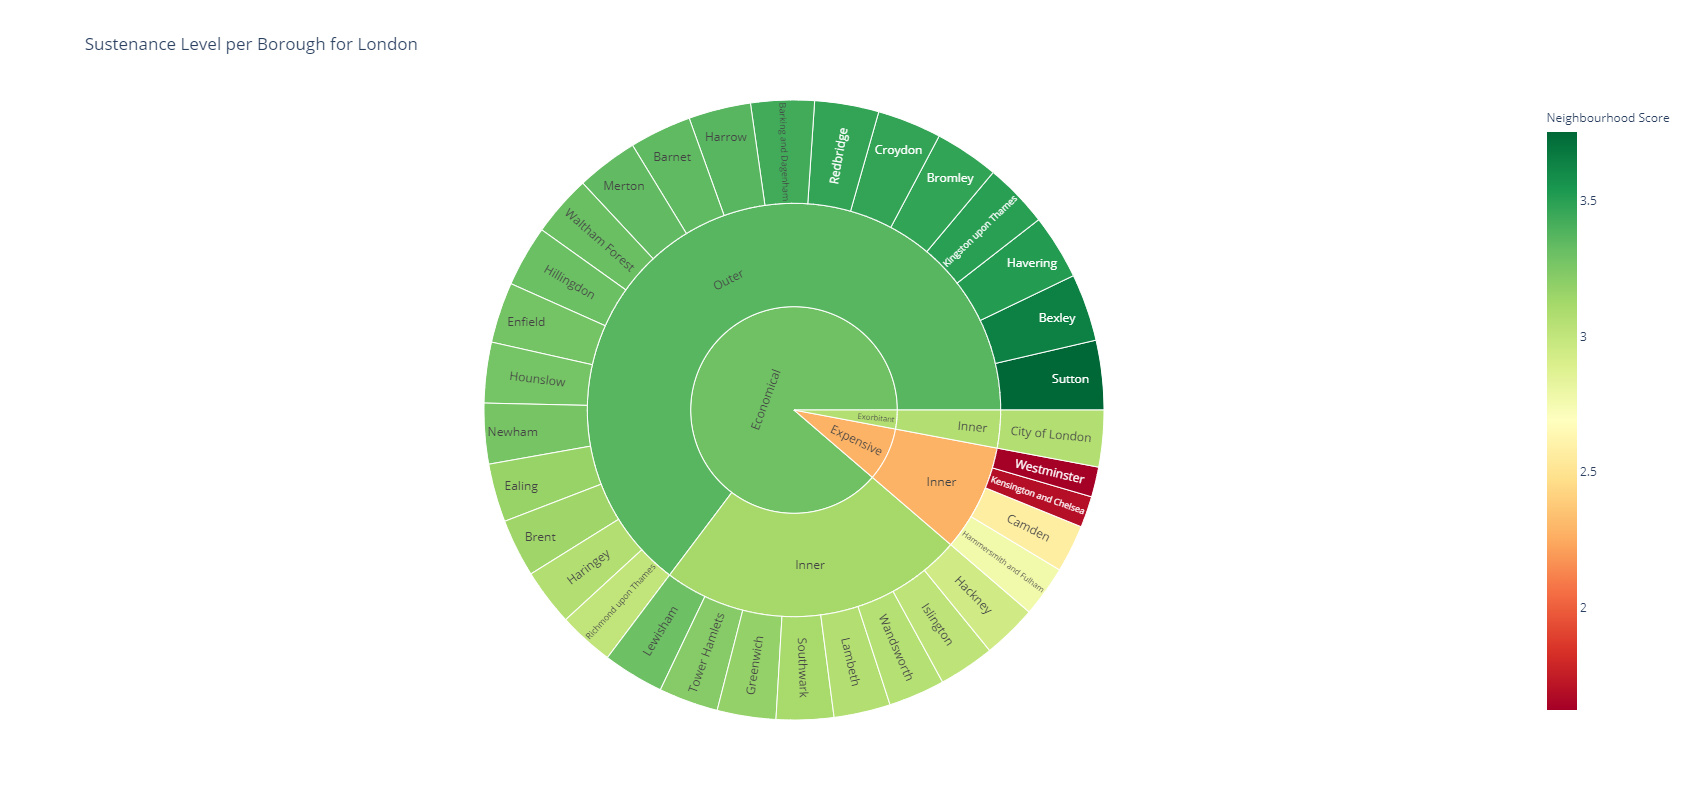

In [49]:
fig = px.sunburst(boroughgrading_df,
                  path=["Sustenance Level","Designation", "Borough"],
                  values='Neighbourhood Score',
                  color='Neighbourhood Score',
                  color_continuous_scale="RdYlGn",
                  title="Sustenance Level per Borough for London",
                  width=800, height=800)
fig.show()

In [50]:
boroughgrading_df =  pd.merge(boroughgrading_df, london_merged[['Borough','Latitude','Longitude','Avg. Rent 2020','Cluster Labels']], how="left", on=["Borough"])
print('Shape of boroughgrading_df : {}'.format(boroughgrading_df.shape))

Shape of boroughgrading_df : (33, 8)


In [51]:
boroughgrading_df.head()

Borough Designation Sustenance Level  Neighbourhood Score  \
0          City of London       Inner       Exorbitant             3.060506   
1             Westminster       Inner        Expensive             1.623881   
2  Kensington and Chelsea       Inner        Expensive             1.689735   
3                  Camden       Inner        Expensive             2.569996   
4  Hammersmith and Fulham       Inner        Expensive             2.768585   

   Latitude  Longitude  Avg. Rent 2020  Cluster Labels  
0  51.52050   -0.09743     2071.000000               2  
1  51.50010   -0.12803     2840.916667               0  
2  51.52266   -0.20793     3001.867470               0  
3  51.53236   -0.12796     2027.228916               0  
4  51.48260   -0.21288     2022.930481               0

In [52]:
# create a plain world map
cluster_london_map = folium.Map(location= [location.latitude,location.longitude], zoom_start=10)


cluster_london_map.choropleth(
    geo_data=london_geo,
    data=boroughgrading_df,
    columns=['Borough','Neighbourhood Score'],
    key_on='feature.properties.name',
    fill_color='YlOrBr', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighbourhood Score'
)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,sustenance in zip(boroughgrading_df['Latitude'],boroughgrading_df['Longitude'], boroughgrading_df['Borough'], boroughgrading_df['Cluster Labels'], boroughgrading_df['Sustenance Level']):
    label = folium.Popup(str(poi) + ' : ' + sustenance + ' Sustenance ', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_london_map)
       
# display map
cluster_london_map

In [53]:
boroughgrading_df[boroughgrading_df['Sustenance Level'] == 'Economical'].sort_values('Neighbourhood Score', ascending=False)

Borough Designation Sustenance Level  Neighbourhood Score  \
32                Sutton       Outer       Economical             3.752440   
31                Bexley       Outer       Economical             3.644374   
30              Havering       Outer       Economical             3.515389   
29  Kingston upon Thames       Outer       Economical             3.497726   
28               Bromley       Outer       Economical             3.473327   
27               Croydon       Outer       Economical             3.470738   
26             Redbridge       Outer       Economical             3.469958   
25  Barking and Dagenham       Outer       Economical             3.429029   
24                Harrow       Outer       Economical             3.364643   
23                Barnet       Outer       Economical             3.345985   
22                Merton       Outer       Economical             3.337109   
21        Waltham Forest       Outer       Economical             3.313820   
20            Hillingdon       Outer       Economical             3.307263   
12              Lewisham       Inner       Economical             3.305107   
19               Enfield       Outer       Economical             3.281500   
18              Hounslow       Outer       Economical             3.276462   
17                Newham       Outer       Economical             3.270877   
11         Tower Hamlets       Inner       Economical             3.220094   
10             Greenwich       Inner       Economical             3.173046   
16                Ealing       Outer       Economical             3.159853   
15                 Brent       Outer       Economical             3.135216   
9              Southwark       Inner       Economical             3.103356   
14              Haringey       Outer       Economical             3.065031   
8                Lambeth       Inner       Economical             3.059469   
7             Wandsworth       Inner       Economical             3.050591   
6              Islington       Inner       Economical             3.019902   
13  Richmond upon Thames       Outer       Economical             3.003035   
5                Hackney       Inner       Economical             2.939945   

     Latitude  Longitude  Avg. Rent 2020  Cluster Labels  
32  51.486004  -0.269183     1137.150685               1  
31  51.452078   0.069931     1111.702381               1  
30  51.544610  -0.144260     1173.688312               1  
29  51.410881  -0.291933     1297.031915               1  
28  51.601511  -0.066365     1317.445087               1  
27  51.593480  -0.083420     1149.169399               1  
26  51.475773  -0.080698     1310.815126               1  
25  51.543932   0.133157     1208.235294               1  
24  51.513180  -0.106980     1449.181818               1  
23  51.527095  -0.066826     1481.329341               1  
22  51.415640  -0.191420     1647.867188               1  
21  51.630613  -0.016275     1355.307143               1  
20  51.484230  -0.096477     1244.778626               1  
12  51.459160  -0.012130     1315.432432               1  
19  51.540024  -0.077502     1303.870370               1  
18  51.471393  -0.351374     1420.363636               1  
17  51.519716   0.051479     1473.013158               1  
11  51.520220  -0.054310     1810.732026               1  
10  51.484540   0.002750     1497.451613               1  
16  51.514060  -0.300730     1563.243802               1  
15  51.609783  -0.194672     1487.036036               1  
9   51.505410  -0.089190     1706.084746               1  
14  51.589270  -0.106405     1638.631579               1  
8   51.490840  -0.111080     1864.196581               1  
7   51.456820  -0.194520     1940.881657               1  
6   51.532790  -0.106140     1949.666667               1  
13  51.480270  -0.237540     1944.076087               1  
5   51.545050  -0.055320     1861.706294               1

In [54]:
eco_london_map = folium.Map(location= [location.latitude,location.longitude], zoom_start=10)


eco_london_map.choropleth(
    geo_data=london_geo,
    data=boroughgrading_df[boroughgrading_df['Sustenance Level'] == 'Economical'],
    columns=['Borough','Neighbourhood Score'],
    key_on='feature.properties.name',
    fill_color='PuBuGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighbourhood Score'
)

eco_london_map